# Análisis sobre el impacto del bitcoin en la macroeconomía de El Salvador

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest


## 1. Obtención de datos

En esta sección veremos los datos que utilizaremos para el análisis:

- Deuda pública de El Salvador
- Índice de precios al consumidor (IPC)
- Producto interno bruto (PIB) de El Salvador
- Inversión extranjera
- Precio histórico del bitcoin

Para lo cual solo extraeremos el dataframe y **ordenaremos**, **limpiaremos** y **filtraremos** los datos para las fechas del 2019 al 2022

### 1.1 Deuda pública de El Salvador

In [2]:
ruta = "Datos_bitcoin/Deuda_SV/Deuda_Externa_Pública_Total.csv"
df = pd.read_csv(ruta, encoding='utf-8', sep=",",skiprows=4, skipfooter=2,engine="python") 
df = df.iloc[:7]
df[" "]=[
    'Total Deuda Externa Pública',
    'Total Sectores Público No Financiero',
    'Gobierno Central','Resto Del Gobierno Central',
    'Empresas Públicas No Financieras',
    'Total Sectores Públicos Financiero',
    'Banco Central De Reserva' ]
df.columns = ['Años', '2019', '2020', '2021', '2022']
df_DPE_concepto = df.set_index('Años').T
df_DPE_concepto["Gobierno Central"] = df_DPE_concepto["Gobierno Central"].values + df_DPE_concepto["Resto Del Gobierno Central"].values
df_DPE_concepto.drop(columns="Resto Del Gobierno Central", axis=1,inplace=True)
df_DPE_concepto.index = pd.date_range("2019-01-01", periods=4, freq="YE")
df_DPE_concepto


Años,Total Deuda Externa Pública,Total Sectores Público No Financiero,Gobierno Central,Empresas Públicas No Financieras,Total Sectores Públicos Financiero,Banco Central De Reserva
2019-12-31,9981.44,9636.70,9094.60,542.09,234.45,110.29
2020-12-31,11152.88,10745.16,10209.14,536.01,240.07,167.65
2021-12-31,11921.86,11454.13,10964.84,489.29,325.92,141.81
2022-12-31,11618.73,11123.60,10642.81,480.79,409.17,85.97


In [3]:
df_DPE = df_DPE_concepto["Total Deuda Externa Pública"]
df_DPE= df_DPE.reset_index()
df_DPE.columns =["Años","Total Deuda Externa Pública"]
df_DPE.set_index("Años", inplace=True)
df_DPE.index = pd.date_range("2019-01-01", "2022-12-31", freq="YE")
df_DPE

,Total Deuda Externa Pública
2019-12-31,9981.44
2020-12-31,11152.88
2021-12-31,11921.86
2022-12-31,11618.73


#### 1.1.1 Diagrama lineal

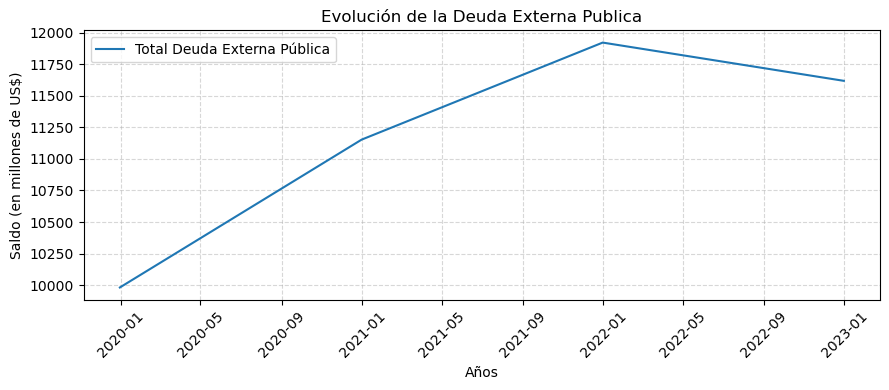

In [4]:
plt.figure(figsize=(9, 4))
for column in df_DPE.columns:
    plt.plot(df_DPE.index, df_DPE[column], label=column)

plt.title("Evolución de la Deuda Externa Publica")
plt.xlabel("Años")
plt.ylabel("Saldo (en millones de US$)")
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

#### 1.1.2 Diagrama Porcentual

In [5]:
df_DPE_Porcentual = df_DPE.pct_change() * 100  # Calcula el porcentaje de cambio
df_DPE_Porcentual = df_DPE_Porcentual.iloc[1:]  
df_DPE_Porcentual.index=['2020', '2021', '2022']   
df_DPE_Porcentual.columns=["Deuda publica porcentual anual"]
df_DPE_Porcentual


,Deuda publica porcentual anual
2020,11.736182
2021,6.894901
2022,-2.542640


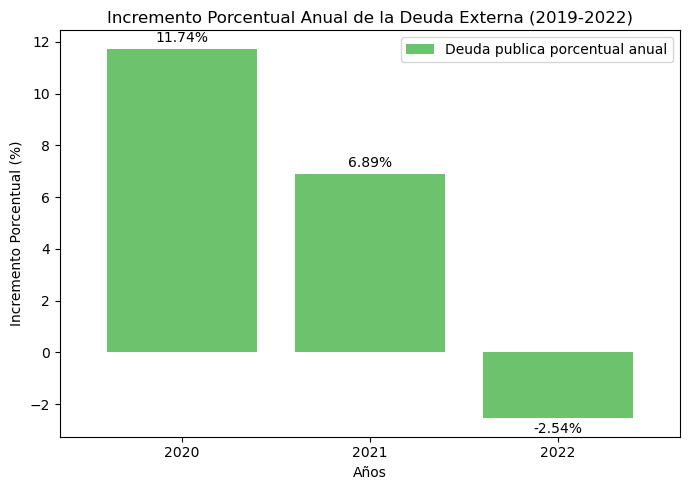

In [6]:
# Graficar el incremento porcentual
DPE = df_DPE_Porcentual.plot(kind="bar", figsize=(7, 5), width=0.8, color="#6DC36D")
# Agregar etiquetas de porcentaje en cada barra
for container in DPE.containers:
    DPE.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, padding=3)

plt.title("Incremento Porcentual Anual de la Deuda Externa (2019-2022)")
plt.xlabel("Años")
plt.ylabel("Incremento Porcentual (%)")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

El 7 de septiembre de 2021, El Salvador adoptó el Bitcoin como moneda legal. Antes de esto, la deuda externa pública del país venía subiendo. Pasó de 9,981.44 millones en 2019 a 11,152.88 millones en 2020, y alcanzó su nivel más alto en 2021 con 11,921.86 millones. Sin embargo, en 2022, la deuda bajó un poco, llegando a 11,618.73 millones

### 1.2 Índice de precios al consumidor (IPC)

In [7]:
ipc_file_path = "Datos_bitcoin/IPC_SV/Índice_de_Precios_al_Consumidor_(IPC).csv"

df_ipc = pd.read_csv(ipc_file_path, encoding='ISO-8859-1', sep=",", skiprows=4)
df_ipc = df_ipc.iloc[:-2]

data = {}
fechas = pd.date_range(start="2019-01-01", end="2022-12-31", freq="ME")
columnas = [
    "Índice general", 
    "Alimentos y bebidas no alcohólicas", 
    "Bebidas alcohólicas, tabaco", 
    "Prendas de vestir y calzado",
    "Alojamiento, agua, electricidad, gas y otros combustibles"    ,
    "Muebles, artículos para el hogar y para la conservación ordinaria del hogar",
    "Salud",
    "Transporte",
    "Comunicaciones",
    "Recreación y cultura",
    "Educación",
    "Restaurantes y hoteles",
    "Bienes y servicios diversos"
]

for i in range(0, len(df_ipc)):
    data[i] = df_ipc.iloc[i, 1:-1].values

df_ipc = pd.DataFrame(data)
df_ipc.columns = columnas
df_ipc.index = fechas
df_ipc.index.name = "Fecha"
df_ipc = df_ipc.astype(float)
df_ipc.head()

,Índice general,Alimentos y bebidas no alcohólicas,"Bebidas alcohólicas, tabaco",Prendas de vestir y calzado,"Alojamiento, agua, electricidad, gas y otros combustibles","Muebles, artículos para el hogar y para la conservación ordinaria del hogar",Salud,Transporte,Comunicaciones,Recreación y cultura,Educación,Restaurantes y hoteles,Bienes y servicios diversos
Fecha,,,,,,,,,,,,,
2019-01-31,112.24,120.81,147.30,92.76,137.52,100.29,99.29,106.83,84.64,87.77,113.27,123.41,107.39
2019-02-28,112.44,121.12,146.86,92.93,137.35,100.52,99.27,107.41,84.32,88.71,113.27,123.37,107.40
2019-03-31,112.69,121.39,146.84,92.89,137.51,100.16,99.27,108.94,84.32,88.48,113.27,123.54,107.55
2019-04-30,112.87,121.71,147.11,92.90,136.16,100.25,99.34,111.01,84.32,88.72,113.27,123.49,107.36
2019-05-31,113.01,122.29,147.74,92.69,135.75,100.30,99.44,111.41,84.31,88.75,113.27,123.57,107.13


#### 1.2.1 Diagrama lineal

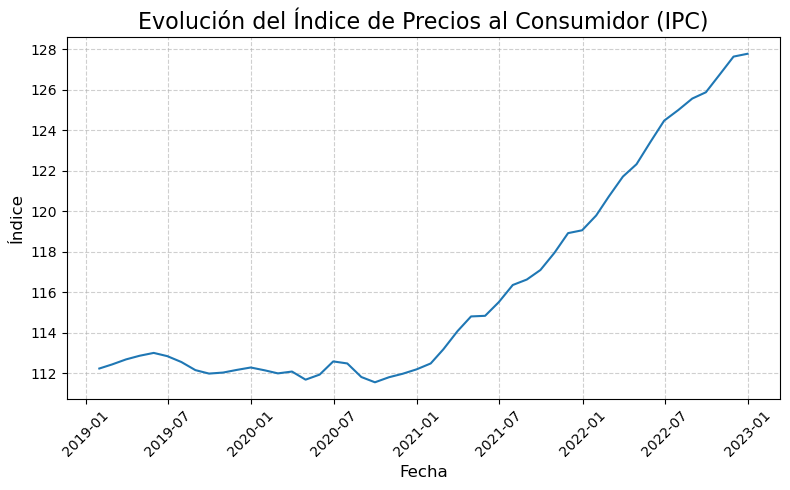

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(df_ipc.index, df_ipc["Índice general"], label=column)
plt.title("Evolución del Índice de Precios al Consumidor (IPC)", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Índice", fontsize=12)
#plt.legend(title="Categorías")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#### 1.2.2 Diagrama procentual 

In [9]:
df_ipc_porcentual =  df_ipc["Índice general"]
df_ipc_porcentual = df_ipc_porcentual.resample("A").last()
df_ipc_porcentual.index=["2019","2020","2021","2022"]
df_ipc_porcentual = df_ipc_porcentual.pct_change()*100
df_ipc_porcentual = df_ipc_porcentual.iloc[1:]  

df_ipc_porcentual

C:\Users\Sheily\AppData\Local\Temp\ipykernel_9408\2033756518.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_ipc_porcentual = df_ipc_porcentual.resample("A").last()


2020   -0.080150
2021    6.114082
2022    7.315639
Name: Índice general, dtype: float64

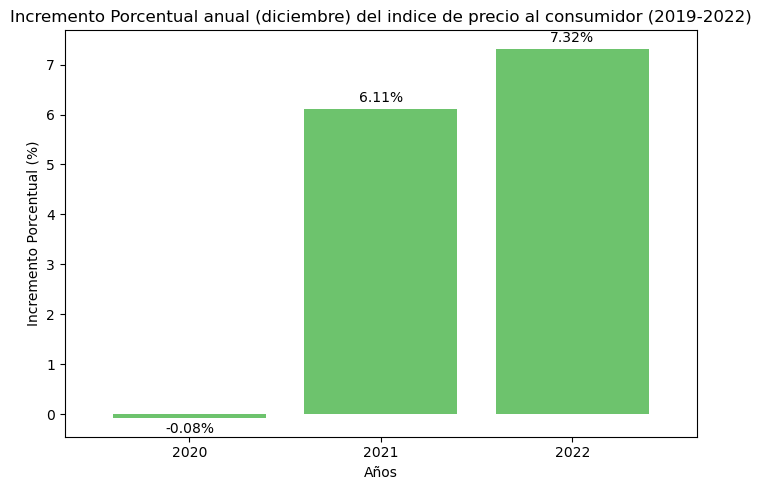

In [10]:
# Graficar el incremento porcentual
IPC = df_ipc_porcentual.plot(kind="bar", figsize=(7, 5), width=0.8, color="#6DC36D")
# Agregar etiquetas de porcentaje en cada barra
for container in IPC.containers:
    IPC.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, padding=3)

plt.title("Incremento Porcentual anual (diciembre) del indice de precio al consumidor (2019-2022)")
plt.xlabel("Años")
plt.ylabel("Incremento Porcentual (%)")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

### 1.3 Producto interno bruto (PIB) de El Salvador

In [11]:
file_path = "Datos_bitcoin/PIB_SV/Producto_Interno_Bruto__Producción_Gasto_e_Ingreso_A_precios_corrientes.csv"

df = pd.read_csv(file_path, encoding='ISO-8859-1', sep=',', skiprows=4)
pib = pd.Series(df.columns[1:])

df_pib = pd.DataFrame(pib, columns=["PIB en millones"])
df_pib.index = [2019, 2020, 2021, 2022, 2023]
df_pib.index.name = "Año"
df_pib["PIB en millones"] = df_pib["PIB en millones"].astype(float)

df_pib_filtered = df_pib.loc[2019:2022]
df_pib_filtered.index = pd.date_range("2019-01-01", periods=4, freq="YE")
df_pib_filtered


,PIB en millones
2019-12-31,26881.14
2020-12-31,24921.19
2021-12-31,29043.14
2022-12-31,31988.92


#### 1.3.1 Diagrama lineal

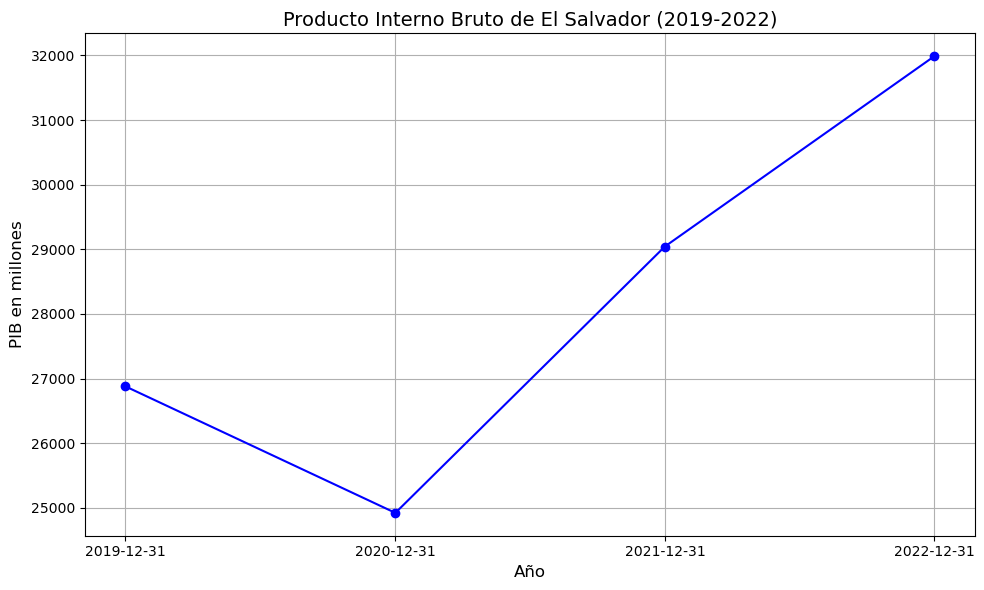

In [12]:
# Código para mostrar el diagrama lineal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_pib_filtered.index, df_pib_filtered["PIB en millones"], marker='o', linestyle='-', color='b')
plt.title("Producto Interno Bruto de El Salvador (2019-2022)", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("PIB en millones", fontsize=12)
plt.grid(True)
plt.xticks(df_pib_filtered.index, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


In [13]:
df_pib = df_pib.iloc[:4]
print(df_pib)
df_pib_porcentual = df_pib.pct_change()*100
df_pib_porcentual = df_pib_porcentual[1:]
print("\nCambio porcentual anual del PIB")
df_pib_porcentual

      PIB en millones
Año                  
2019         26881.14
2020         24921.19
2021         29043.14
2022         31988.92

Cambio porcentual anual del PIB


,PIB en millones
Año,
2020,-7.291171
2021,16.539941
2022,10.142774


#### 1.3.2 Diagrama porcentual

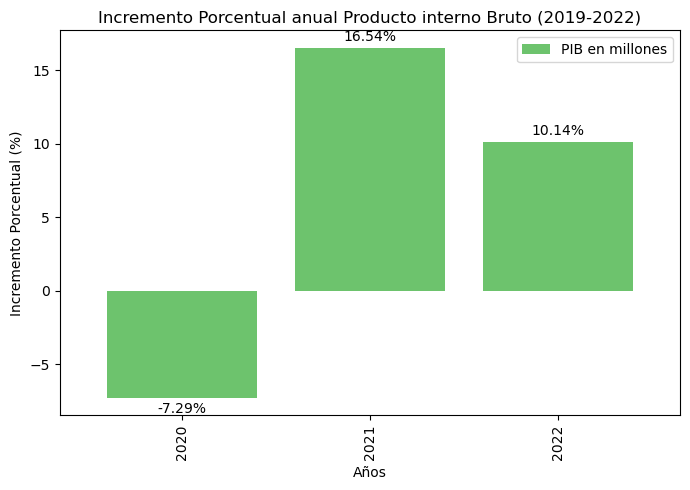

In [14]:
PIB = df_pib_porcentual.plot(kind='bar',figsize=(7,5),width=0.8,color="#6DC36D")
for container in PIB.containers:
    PIB.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, padding=3)

plt.title("Incremento Porcentual anual Producto interno Bruto (2019-2022)")
plt.xlabel("Años")
plt.ylabel("Incremento Porcentual (%)")
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

### 1.4 Inversion extranjera

In [15]:

path_relative = "Datos_bitcoin/Inversion_SV/Posición_de_Inversión_Internacional_a_fin_de_período.csv"

df = pd.read_csv(path_relative, encoding='ISO-8859-1', skiprows=2, header=None)

headers = df.iloc[1, 1:].values  # Fechas
concepts = df.iloc[2:, 0]  # Conceptos (e.g., Posición Neta, Activos)

concepts = concepts.str.replace('Ã³', 'ó').str.replace('Ã±', 'ñ').str.replace('Ã®', 'í')

notes_keywords = ["Notas", "Con el fin de mejorar", "eurobonos emitidos"]
rows_to_keep = ~concepts.str.contains('|'.join(notes_keywords), na=False)

filtered_concepts = concepts[rows_to_keep].reset_index(drop=True)
filtered_data = df.iloc[2:, 1:].loc[rows_to_keep].reset_index(drop=True)

df_data = pd.DataFrame(data=filtered_data.values, index=filtered_concepts, columns=headers)

filtered_columns = [col for col in df_data.columns if str(col).startswith(("2019", "2020", "2021", "2022"))]
df_filtered = df_data[filtered_columns].copy()

df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

df_transformed = df_filtered.T
df_transformed.index.name = 'Fecha'
df_transformed.columns.name = 'Concepto'

df_transformed = df_transformed.dropna(how='all')

df_transformed.index = pd.date_range(start="2019-03-01", freq="QE", periods=16)
df_transformed.head()



Concepto,Posición de Inversión Internacional Neta,Activos,Pasivos
2019-03-31,-16948.47,9945.76,26894.23
2019-06-30,-17321.75,10176.15,27497.90
2019-09-30,-16998.44,11505.66,28504.10
2019-12-31,-17457.13,10895.98,28353.11
2020-03-31,-14330.71,12538.06,26868.77


#### 1.4.1 Diagrama lineal

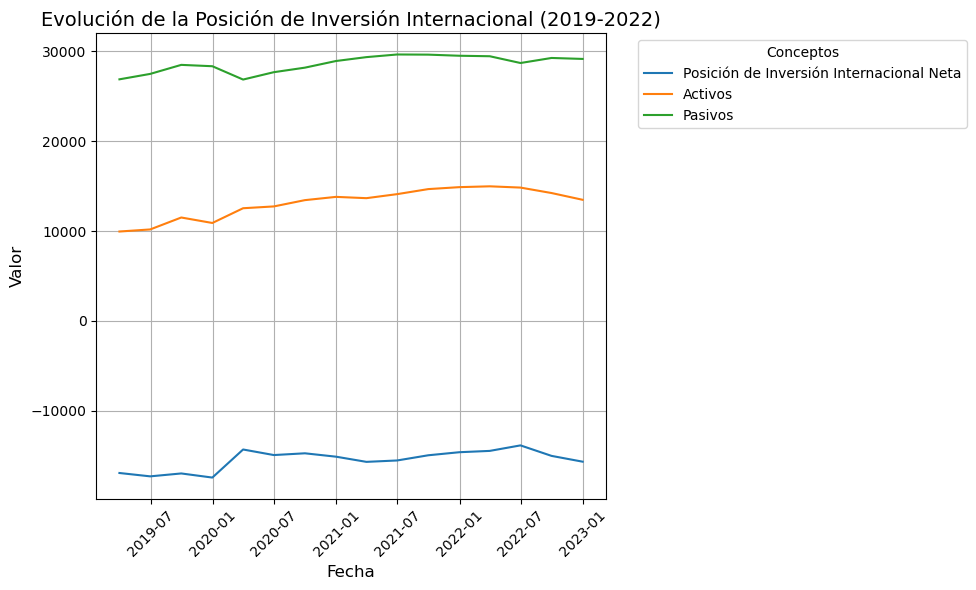

In [16]:

plt.figure(figsize=(10, 6))
for column in df_transformed.columns:
    plt.plot(df_transformed.index, df_transformed[column], label=column)

plt.title('Evolución de la Posición de Inversión Internacional (2019-2022)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Conceptos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


#### 1.4.2 Diagrama porcentual 

In [17]:
iex_porcentual=df_transformed.resample("YE").last()
iex_porcentual = iex_porcentual.pct_change()*100
iex_porcentual = iex_porcentual[1:]
iex_porcentual 


Concepto,Posición de Inversión Internacional Neta,Activos,Pasivos
2020-12-31,-13.323209,26.680757,2.050145
2021-12-31,-3.285842,7.845768,2.024442
2022-12-31,7.203044,-9.459448,-1.199283


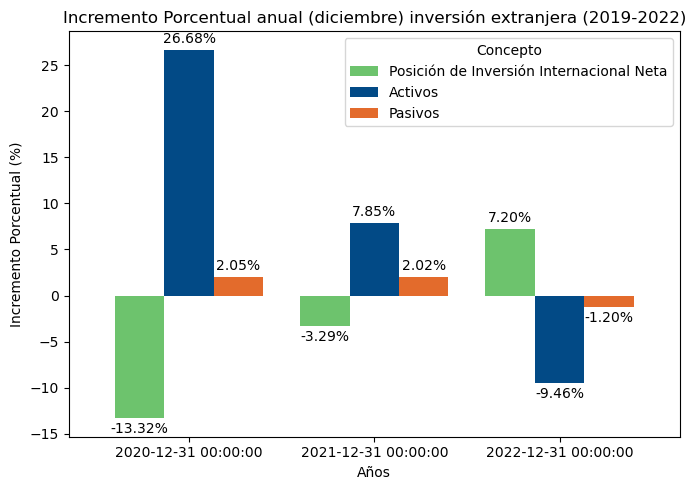

In [18]:
iex = iex_porcentual.plot(kind="bar", figsize=(7,5), width=0.8,color=["#6DC36D","#024A86","#E36B2C"])
for container in iex.containers:
    iex.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, padding=3)

plt.title("Incremento Porcentual anual (diciembre) inversión extranjera (2019-2022)")
plt.xlabel("Años")
plt.ylabel("Incremento Porcentual (%)")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


### 1.5 Precio histórico del Bitcoin

In [19]:
import re

btc_file_path = "Datos_bitcoin/btc history/Bitcoin history.csv"
df_btc = pd.read_csv(btc_file_path, encoding='ISO-8859-1', sep=",")

df_btc.rename(columns={'ï»¿"Date"': 'Date'}, inplace=True)
df_btc.set_index("Date", inplace=True)

df_btc.index = pd.to_datetime(df_btc.index, format="%b %d, %Y")
df_btc = df_btc.sort_index()
df_btc = df_btc.loc['2019-01-01':'2022-12-31']

df_btc = df_btc.map(lambda x: re.sub(r"[,%]", "", x) if isinstance(x, str) else x)
df_btc = df_btc.astype({"Price": float, "Open": float, "High": float, "Low": float, "Change %": float})
df_btc.head()



,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-01,3809.4,3709.5,3814.3,3664.4,469.11K,2.69
2019-01-02,3873.8,3809.7,3894.8,3768.1,554.47K,1.69
2019-01-03,3780.1,3874.1,3875.8,3753.0,450.32K,-2.42
2019-01-04,3802.7,3780.5,3823.9,3720.0,488.70K,0.60
2019-01-05,3785.4,3802.8,3846.7,3769.0,468.45K,-0.46


#### 1.5.1 Diagrama lineal

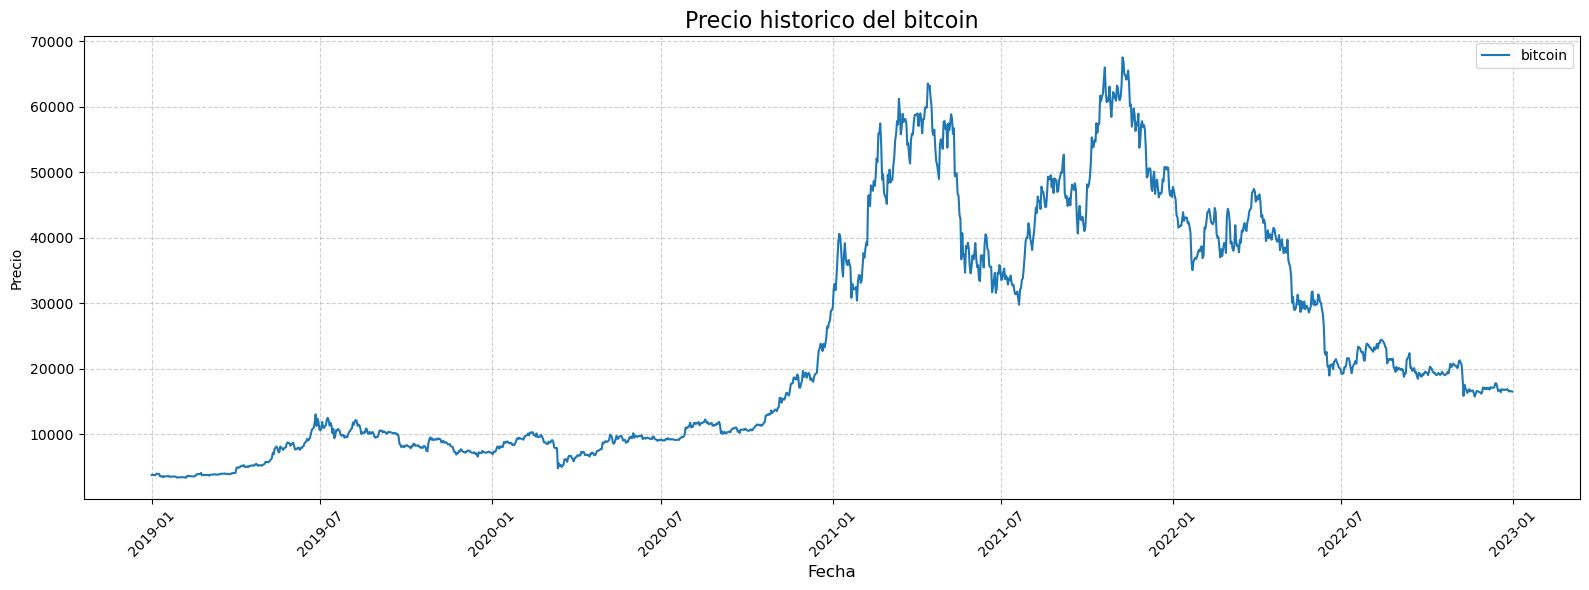

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(df_btc.index, df_btc["Price"], label="bitcoin")

plt.title("Precio historico del bitcoin", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Precio")
plt.legend()

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#### 1.5.2 Diagrama porcentual

In [21]:
df_btc_porcentual = df_btc["Price"]
df_btc_porcentual = df_btc_porcentual.resample("YE").last()
print(df_btc_porcentual)
df_btc_porcentual = df_btc_porcentual.pct_change()*100
df_btc_porcentual = df_btc_porcentual[1:]
df_btc_porcentual


Date
2019-12-31     7196.4
2020-12-31    28949.4
2021-12-31    46219.5
2022-12-31    16537.4
Freq: YE-DEC, Name: Price, dtype: float64


Date
2020-12-31    302.276138
2021-12-31     59.656159
2022-12-31    -64.219864
Freq: YE-DEC, Name: Price, dtype: float64

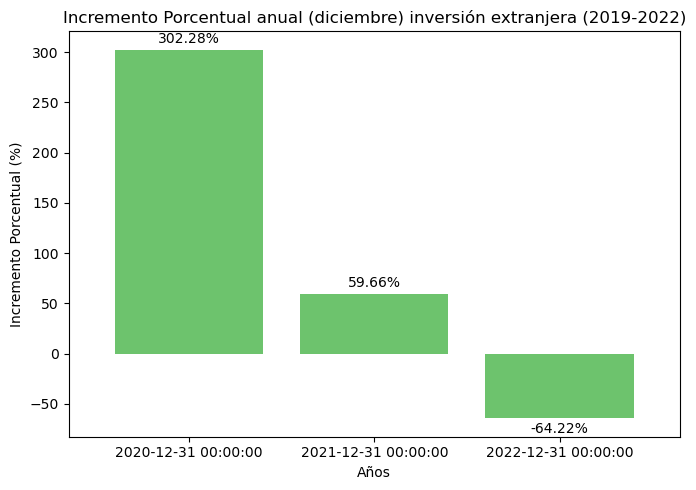

In [22]:
BTC = df_btc_porcentual.plot(kind="bar",figsize=(7,5),width=0.8,color="#6DC36D")

for container in BTC.containers:
    BTC.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, padding=3)

plt.title("Incremento Porcentual anual (diciembre) inversión extranjera (2019-2022)")
plt.xlabel("Años")
plt.ylabel("Incremento Porcentual (%)")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()


### 1.6 Reserva nacional

In [23]:
import pandas as pd
btc_file_path = "Datos_bitcoin/Reservas_BCR/Reservas_Internacionales_Netas_BCR.csv"
csv = pd.read_csv(btc_file_path, sep=",")
df_reserva = pd.DataFrame(csv)

df_reserva.drop(index=[0,1,6], axis=0, inplace=True)
df_reserva.columns = df_reserva.iloc[0]
df_reserva.drop(index=2, axis=0, inplace=True)
df_reserva = df_reserva.T
df_reserva.columns = df_reserva.iloc[0]
df_reserva.drop(index=['Concepto'],inplace=True)
df_reserva.to_csv('Datos_bitcoin/Reservas_BCR/reservasinternacionales.csv')
df_reserva2 = pd.read_csv('Datos_bitcoin/Reservas_BCR/reservasinternacionales.csv') #dataframe ya procesado

df_reserva2.index = df_reserva2["2"]
df_reserva2.drop("2", axis=1, inplace=True)
df_reserva2.index.name = "Fecha"
df_reserva2.index = pd.date_range("2019-01-01", "2022-12-31", freq="ME")
df_reserva2.head()

,Reservas Internacionales Netas,Activos de Reserva,PASIVOS EXTERNOS DE CORTO PLAZO
2019-01-31,3493.55,3662.09,168.54
2019-02-28,3615.30,4275.36,660.06
2019-03-31,3594.41,3868.56,274.16
2019-04-30,3712.89,4014.25,301.37
2019-05-31,3765.82,4571.11,805.29


#### 1.6.1 Diagrama lineal

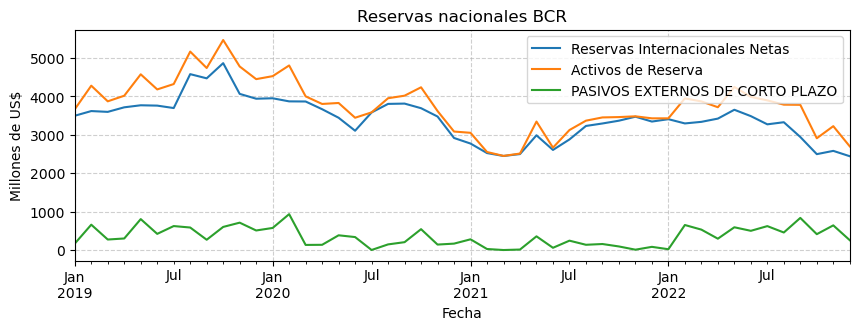

In [24]:
df_reserva2.plot(kind='line',figsize=(10, 3),fontsize=10)
plt.title('Reservas nacionales BCR')
plt.xlabel('Fecha'), plt.ylabel('Millones de US$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

A pesar de la adopción del bitcoin como activo de reserva, los datos reflejados por el BCR muetran que las la mayoría de indicadores de reservas nacionales han decaido desde la adopción del bitcoin, por medio de la documentación del BCR acerca de estos datos no se puede precisar si el bitcoin se toma en cuenta en estos indicadores, pero se puede suponer que el indicador relacionado con las reservas en bitcoin sería 'PASIVOS EXTERNOS DE CORTO PLAZO', este indicador tuvo un aumento del +52% entre el primer mes del 2019 y el ultimo mes de 2022.

#### 1.6.1 Diagrama porcentual

In [25]:
df_rn_porcentual = df_reserva2.resample("A").last()
df_rn_porcentual = df_rn_porcentual.pct_change()*100
df_rn_porcentual = df_rn_porcentual.iloc[1:]
df_rn_porcentual


C:\Users\Sheily\AppData\Local\Temp\ipykernel_9408\672639151.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_rn_porcentual = df_reserva2.resample("A").last()


,Reservas Internacionales Netas,Activos de Reserva,PASIVOS EXTERNOS DE CORTO PLAZO
2020-12-31,-25.944179,-30.659031,-67.101259
2021-12-31,14.653883,11.138143,-50.038794
2022-12-31,-26.985181,-21.293015,205.984948


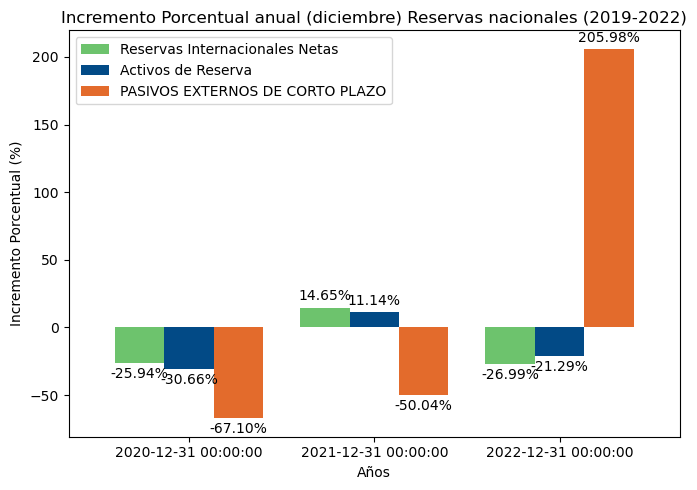

In [26]:
RN = df_rn_porcentual.plot(kind="bar", figsize=(7,5),width=0.8,color=["#6DC36D","#024A86","#E36B2C"]) 
for container in RN.containers:
    RN.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=10, padding=3)

plt.title("Incremento Porcentual anual (diciembre) Reservas nacionales (2019-2022)")
plt.xlabel("Años")
plt.ylabel("Incremento Porcentual (%)")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

## 2. Análisis de datos

### 2.1 Interpolando datos

Primero, interpolaremos los datos para rellenar fechas que falten, y así que todos los indices coincidan para correlacionar los datos

In [27]:
#Fechas que queremos para todos los datos
pd.date_range(df_btc.index.min(), df_btc.index.max(), freq="D")

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=1461, freq='D')

Ahora cargaremos los datos que nos interesan de cada dataset en un nuevo dataframe

In [28]:
df_btc = df_btc[["Price"]] #Precio del bitcoin
df_rin = df_reserva2[["Reservas Internacionales Netas"]] # Reservas internacionales
df_niip = df_transformed[["Posición de Inversión Internacional Neta"]] # Posicion de inversión
df_pib = df_pib_filtered[["PIB en millones"]] # Bienes y servicios producidos
df_ipc = df_ipc[["Índice general"]] # Indice de precios al consumidor
df_dpe = df_DPE_concepto[["Total Deuda Externa Pública"]] # Deuda externa pública del estado

Ya teniendo los dataframes para cada dato de interés, procedemos a reindexar:

In [29]:
df_dpe = df_dpe.reindex(pd.date_range(df_btc.index.min(), df_btc.index.max(), freq="D"))
df_rin = df_rin.reindex(pd.date_range(df_btc.index.min(), df_btc.index.max(), freq="D"))
df_niip = df_niip.reindex(pd.date_range(df_btc.index.min(), df_btc.index.max(), freq="D"))
df_pib = df_pib.reindex(pd.date_range(df_btc.index.min(), df_btc.index.max(), freq="D"))
df_ipc = df_ipc.reindex(pd.date_range(df_btc.index.min(), df_btc.index.max(), freq="D"))


#Asignamos manualmente el valor del primer día para poder interpolar correctamente
df_dpe.loc["2019-01-01"]  = 9565.43 
df_rin.loc["2019-01-01"]  = 3353.55
df_niip.loc["2019-01-01"] = -16709.87
df_pib.loc["2019-01-01"]  = 26020.85
df_ipc.loc["2019-01-01"]  = 112.30

Ahora que tenemos todos los dataframes, con su fechas diarias, procedemos a interpolar los datos con el metodo **linear** para llenar los valores NaN

In [30]:
df_dpe.interpolate(method="linear", inplace=True)
df_rin.interpolate(method="linear", inplace=True)
df_niip.interpolate(method="linear", inplace=True)
df_pib.interpolate(method="linear", inplace=True)
df_ipc.interpolate(method="linear", inplace=True)

df_ipc.head()

,Índice general
2019-01-01,112.300
2019-01-02,112.298
2019-01-03,112.296
2019-01-04,112.294
2019-01-05,112.292


### 2.2 Juntando todos los DataFrame

In [31]:
df_variables = df_btc.join([df_dpe, df_rin, df_niip, df_pib, df_ipc])
# Cambiando el nombre de todas las columnas
df_variables.columns = ["precio_bitcoin", "dep", "rin", "niip", "pib", "igpc"]

df_variables.head()

,precio_bitcoin,dep,rin,niip,pib,igpc
Date,,,,,,
2019-01-01,3809.4,9565.430000,3353.550000,-16709.870000,26020.850000,112.300
2019-01-02,3873.8,9566.572885,3358.216667,-16712.550899,26023.213434,112.298
2019-01-03,3780.1,9567.715769,3362.883333,-16715.231798,26025.576868,112.296
2019-01-04,3802.7,9568.858654,3367.550000,-16717.912697,26027.940302,112.294
2019-01-05,3785.4,9570.001538,3372.216667,-16720.593596,26030.303736,112.292


Nombres cambiados:

- **dep**:  deuda pública externa
- **rin**:  reservas internacionales netas
- **niip**: posicion de inversión internacional neta
- **pib**:  producto interno bruto
- **igpc**: índice general de precios al consumidor

### 2.3 Entendiendo datos

- Tamaño: ``shape``
- Exploración: ``head`` and ``tail``
- Tipos de datos: ``dtypes``
- Estadísticos: ``describe``

In [32]:
df_variables.shape

(1461, 6)

In [33]:
df_variables.head()

,precio_bitcoin,dep,rin,niip,pib,igpc
Date,,,,,,
2019-01-01,3809.4,9565.430000,3353.550000,-16709.870000,26020.850000,112.300
2019-01-02,3873.8,9566.572885,3358.216667,-16712.550899,26023.213434,112.298
2019-01-03,3780.1,9567.715769,3362.883333,-16715.231798,26025.576868,112.296
2019-01-04,3802.7,9568.858654,3367.550000,-16717.912697,26027.940302,112.294
2019-01-05,3785.4,9570.001538,3372.216667,-16720.593596,26030.303736,112.292


In [34]:
df_variables.tail()

,precio_bitcoin,dep,rin,niip,pib,igpc
Date,,,,,,
2022-12-27,16706.1,11622.051973,2458.432258,-15660.138696,31956.637479,127.751935
2022-12-28,16546.2,11621.221479,2453.934194,-15667.151522,31964.708110,127.756452
2022-12-29,16636.4,11620.390986,2449.436129,-15674.164348,31972.778740,127.760968
2022-12-30,16607.2,11619.560493,2444.938065,-15681.177174,31980.849370,127.765484
2022-12-31,16537.4,11618.730000,2440.440000,-15688.190000,31988.920000,127.770000


In [35]:
df_variables.dtypes

precio_bitcoin    float64
dep               float64
rin               float64
niip              float64
pib               float64
igpc              float64
dtype: object

In [36]:
df_variables.describe()

,precio_bitcoin,dep,rin,niip,pib,igpc
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,23511.497947,10912.389257,3420.521783,-15522.094446,27463.268056,116.009367
std,17551.132555,825.974265,523.757986,1038.197124,1973.069230,5.062892
min,3397.700000,9565.430000,2440.440000,-17457.130000,24921.190000,111.560000
25%,9135.400000,9984.640656,3149.208387,-16760.807079,26110.012131,112.173871
50%,17125.700000,11152.880000,3423.854000,-15190.279348,26632.979423,112.892667
75%,38709.700000,11704.270795,3743.790000,-14761.278696,29043.140000,119.060000
max,67527.900000,11921.860000,4861.350000,-13873.190000,31988.920000,127.770000


### 2.4 Preparación y limpieza de datos

- Valores faltantes.
- Identificar filas duplicadas.
- Revisión de valores atípicos.
- Análisis de consistencia de los datos.
- Selección de variables.

In [37]:
df_variables.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2019-01-01 to 2022-12-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   precio_bitcoin  1461 non-null   float64
 1   dep             1461 non-null   float64
 2   rin             1461 non-null   float64
 3   niip            1461 non-null   float64
 4   pib             1461 non-null   float64
 5   igpc            1461 non-null   float64
dtypes: float64(6)
memory usage: 79.9 KB


In [38]:
df_variables[df_variables.duplicated()]

,precio_bitcoin,dep,rin,niip,pib,igpc
Date,,,,,,


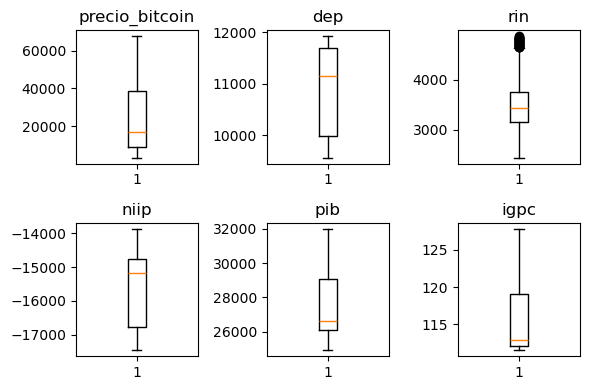

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4))

for ax, col in zip(axes.ravel(), df_variables.columns):
    ax.boxplot(df_variables[col])  # Graficar un gráfico de caja para cada columna
    ax.set_title(col)    # Título con el nombre de la columna

plt.tight_layout()
plt.show()

### 2.5 Ánalisis gráfico de los datos

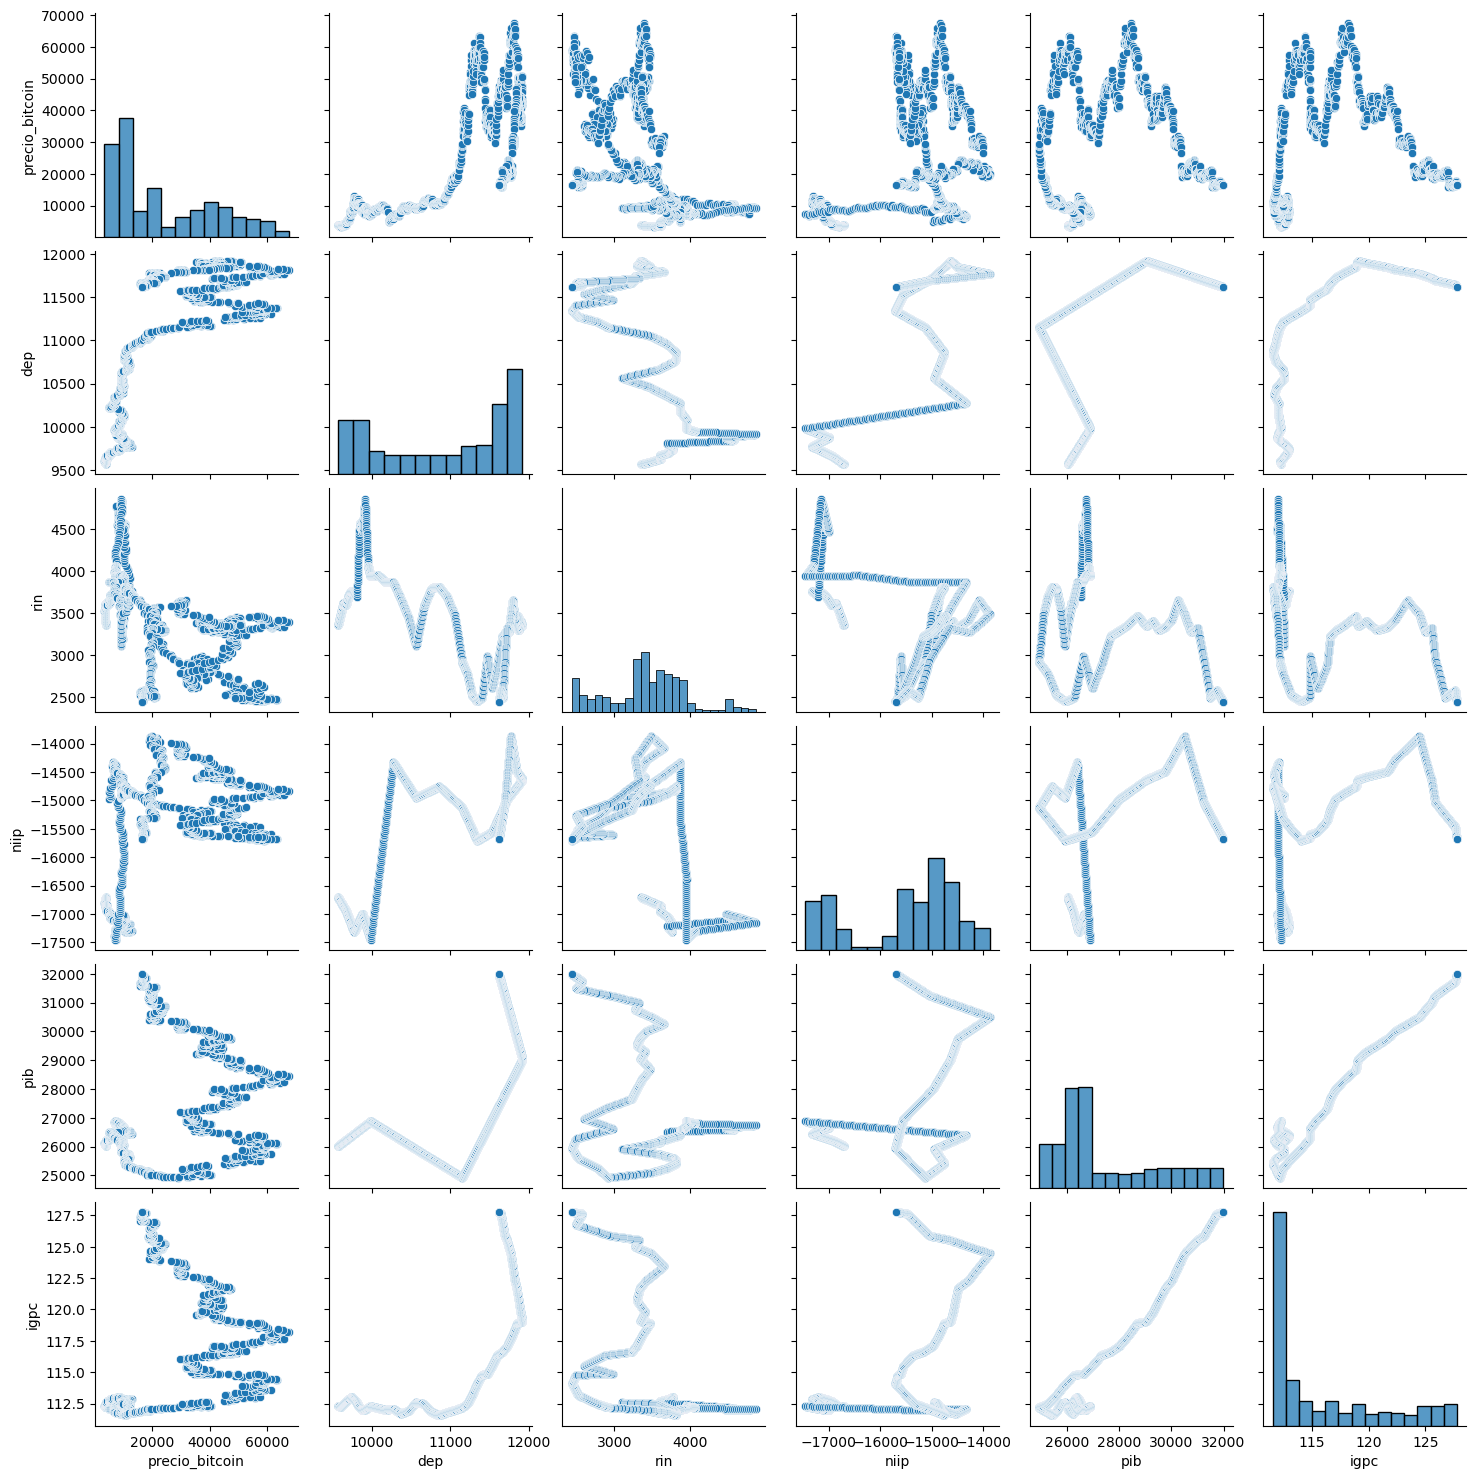

In [40]:
sns.pairplot(df_variables)

### 2.6 Análisis de normalidad

Maneras en las que evaluaremos la normalidad de nuestros datos:

- Evaluación gráfica
- Test estadístico

#### 2.6.1 Método gráfico: qqplot

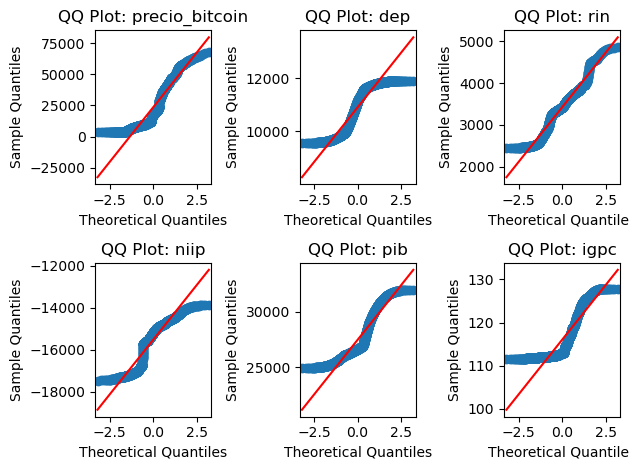

In [41]:
fig, axes = plt.subplots(2, 3)
axes = axes.ravel()
# Generar QQ plots para cada columna
for i, col in enumerate(df_variables.columns):
    sm.qqplot(df_variables[col], line='s', ax=axes[i])
    axes[i].set_title(f'QQ Plot: {col}')

plt.tight_layout()
plt.show()

#### 2.6.2 Método estadístico

In [42]:
# Función para aplicar el test de Kolmogórov-Smirnov a una columna
def kolmogorov_test(column):
    statistic, p_value = kstest(column, 'norm')  # Compara contra la distribución normal
    return pd.Series({'KS_Statistic': statistic, 'p_value': p_value})

# Aplicar el test a cada columna
resultado = df_variables.apply(kolmogorov_test, axis=0).T
print(resultado, end="\n\n\n")

for col in resultado.index:
    p_value = resultado.loc[col, 'p_value']
    if p_value > 0.05: print(f"Columna '{col}': Los datos podrían seguir una distribución normal.")
    else: print(f"Columna '{col}': Los datos no siguen una distribución normal.")

                KS_Statistic  p_value
precio_bitcoin           1.0      0.0
dep                      1.0      0.0
rin                      1.0      0.0
niip                     1.0      0.0
pib                      1.0      0.0
igpc                     1.0      0.0


Columna 'precio_bitcoin': Los datos no siguen una distribución normal.
Columna 'dep': Los datos no siguen una distribución normal.
Columna 'rin': Los datos no siguen una distribución normal.
Columna 'niip': Los datos no siguen una distribución normal.
Columna 'pib': Los datos no siguen una distribución normal.
Columna 'igpc': Los datos no siguen una distribución normal.
